In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [2]:
import numpy as np
import pandas as pd
import umap

from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


np.random.seed(seed=42) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [3]:
X,y = make_classification(n_samples=1000, n_classes=3, weights=[0.5,0.25,0.25], n_features=10,
                          n_informative=5, n_redundant=5, class_sep=0.7, n_clusters_per_class=1,
                          hypercube=True, shuffle=True, random_state=42)

In [4]:
data = pd.DataFrame(X)
labels = pd.Series(y)
# data.hist(figsize=(20,12))

In [5]:
# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, labels, valid_size=0.5)


# original_labels = train_labels.copy()
# train_labels[train_labels > 0] = 1
train_labels.value_counts()

0    248
2    126
1    126
dtype: int64

In [6]:
test_data.shape

(500, 10)

### Note: The labels used for the split are training and NOT original
> ###  Sublcusters may be imbalanced 

In [7]:
X_train = train_data
y_train = train_labels.copy()
y_train[y_train > 0] = 1

X_valid = test_data
y_valid = test_labels.copy()
y_valid[y_valid > 0] = 1

In [8]:
# X_train, y_train, X_valid, y_valid = split_valid(train_data, train_labels, valid_size=0.5)

In [9]:
def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    
    dnn.add(Dense(units = 10, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 10, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))

    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [10]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=25,
                    min_dist=0)

In [11]:
nn = build_dnn(num_features=train_data.shape[1])
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.382, Acc:0.8753
Prediction Accuracy
51/51 [==============================] - 0s 801us/step
Scores on data set: loss=0.189 accuracy=0.9608
Fold Correct: 49
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.386, Acc:0.8864
Prediction Accuracy
51/51 [==============================] - 0s 33us/step
Scores on data set: loss=0.245 accuracy=0.9412
Fold Correct: 48
Running worker: 2
Fold: 2 -> Loss:0.319, Acc:0.8933
Prediction Accuracy
50/50 [==============================] - 0s 37us/step
Scores on data set: loss=0.309 accuracy=0.9200
Fold Correct: 46
Running worker: 3
Fold: 3 -> Loss:0.342, Acc:0.8867
Prediction Accuracy
50/50 [==============================] - 0s 35us/step
Scores on data set: loss=0.231 accuracy=0.9600
Fold Correct: 48
Running worker: 4
Fold: 4 -> Loss:0.369, Acc:0.8889
Prediction Accuracy
50/50 [===

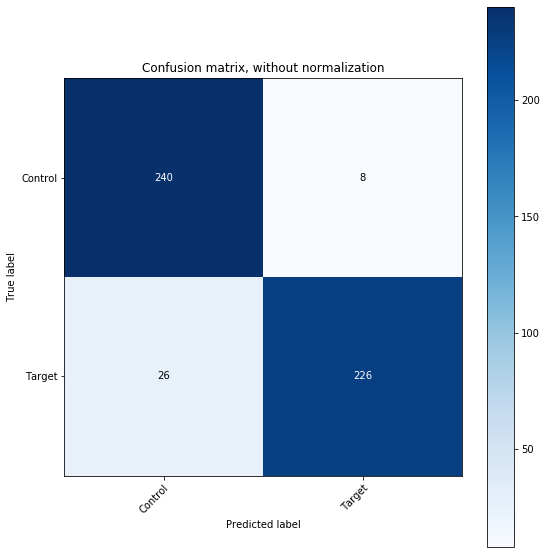

In [13]:
cm = pipeline.train_model(batch_size=20,epochs=50, cross_validation=True, parallel=False, verbose=0)

In [14]:
_, correct_pred_idxs = pipeline.train_clusterer(plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:751

Cluster Search Space: range(23, 27)
Minimum Size:
Clusters                  (23, 23)
Noise                     (23, 23)
Halkidi                   (23, 23)
Halkidi-Filtered Noise    (26, 26)
dtype: object


In [21]:
import cufflinks as cf
py.offline.init_notebook_mode(connected=True)
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')

In [54]:
width=1500
height=2000
cf.set_config_file(dimensions=(width,height))

## Compare LRP w/ Softmax Applied

In [79]:
correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
split_class = correct_pred_labels == pipeline.target_class
split_class_lrp = np.array(pipeline.lrp_results)[split_class]
training_lrp = split_class_lrp #np.clip(split_class_lrp, 0,None)

In [84]:
original_lrp = pd.DataFrame(training_lrp)
original_lrp.head()

,0,1,2,3,4,5,6,7,8,9
0,0.818610,-0.738646,0.148847,0.212074,-0.242197,0.424471,0.043984,-0.264800,0.949852,1.073322
1,0.068747,-0.050693,0.491235,-1.015650,1.158859,1.606405,1.091577,0.135917,0.712867,-0.248140
2,-0.660972,1.807139,-0.088474,1.508124,1.922091,-0.551369,0.152382,0.284232,-1.000787,0.066502
3,0.278838,0.784947,-0.005227,0.581095,1.423226,-0.242881,-0.271375,0.039271,-0.130950,0.618450
4,0.331653,-0.703835,0.149083,0.137321,-0.640929,0.864093,0.468394,-0.135691,0.730392,0.610119


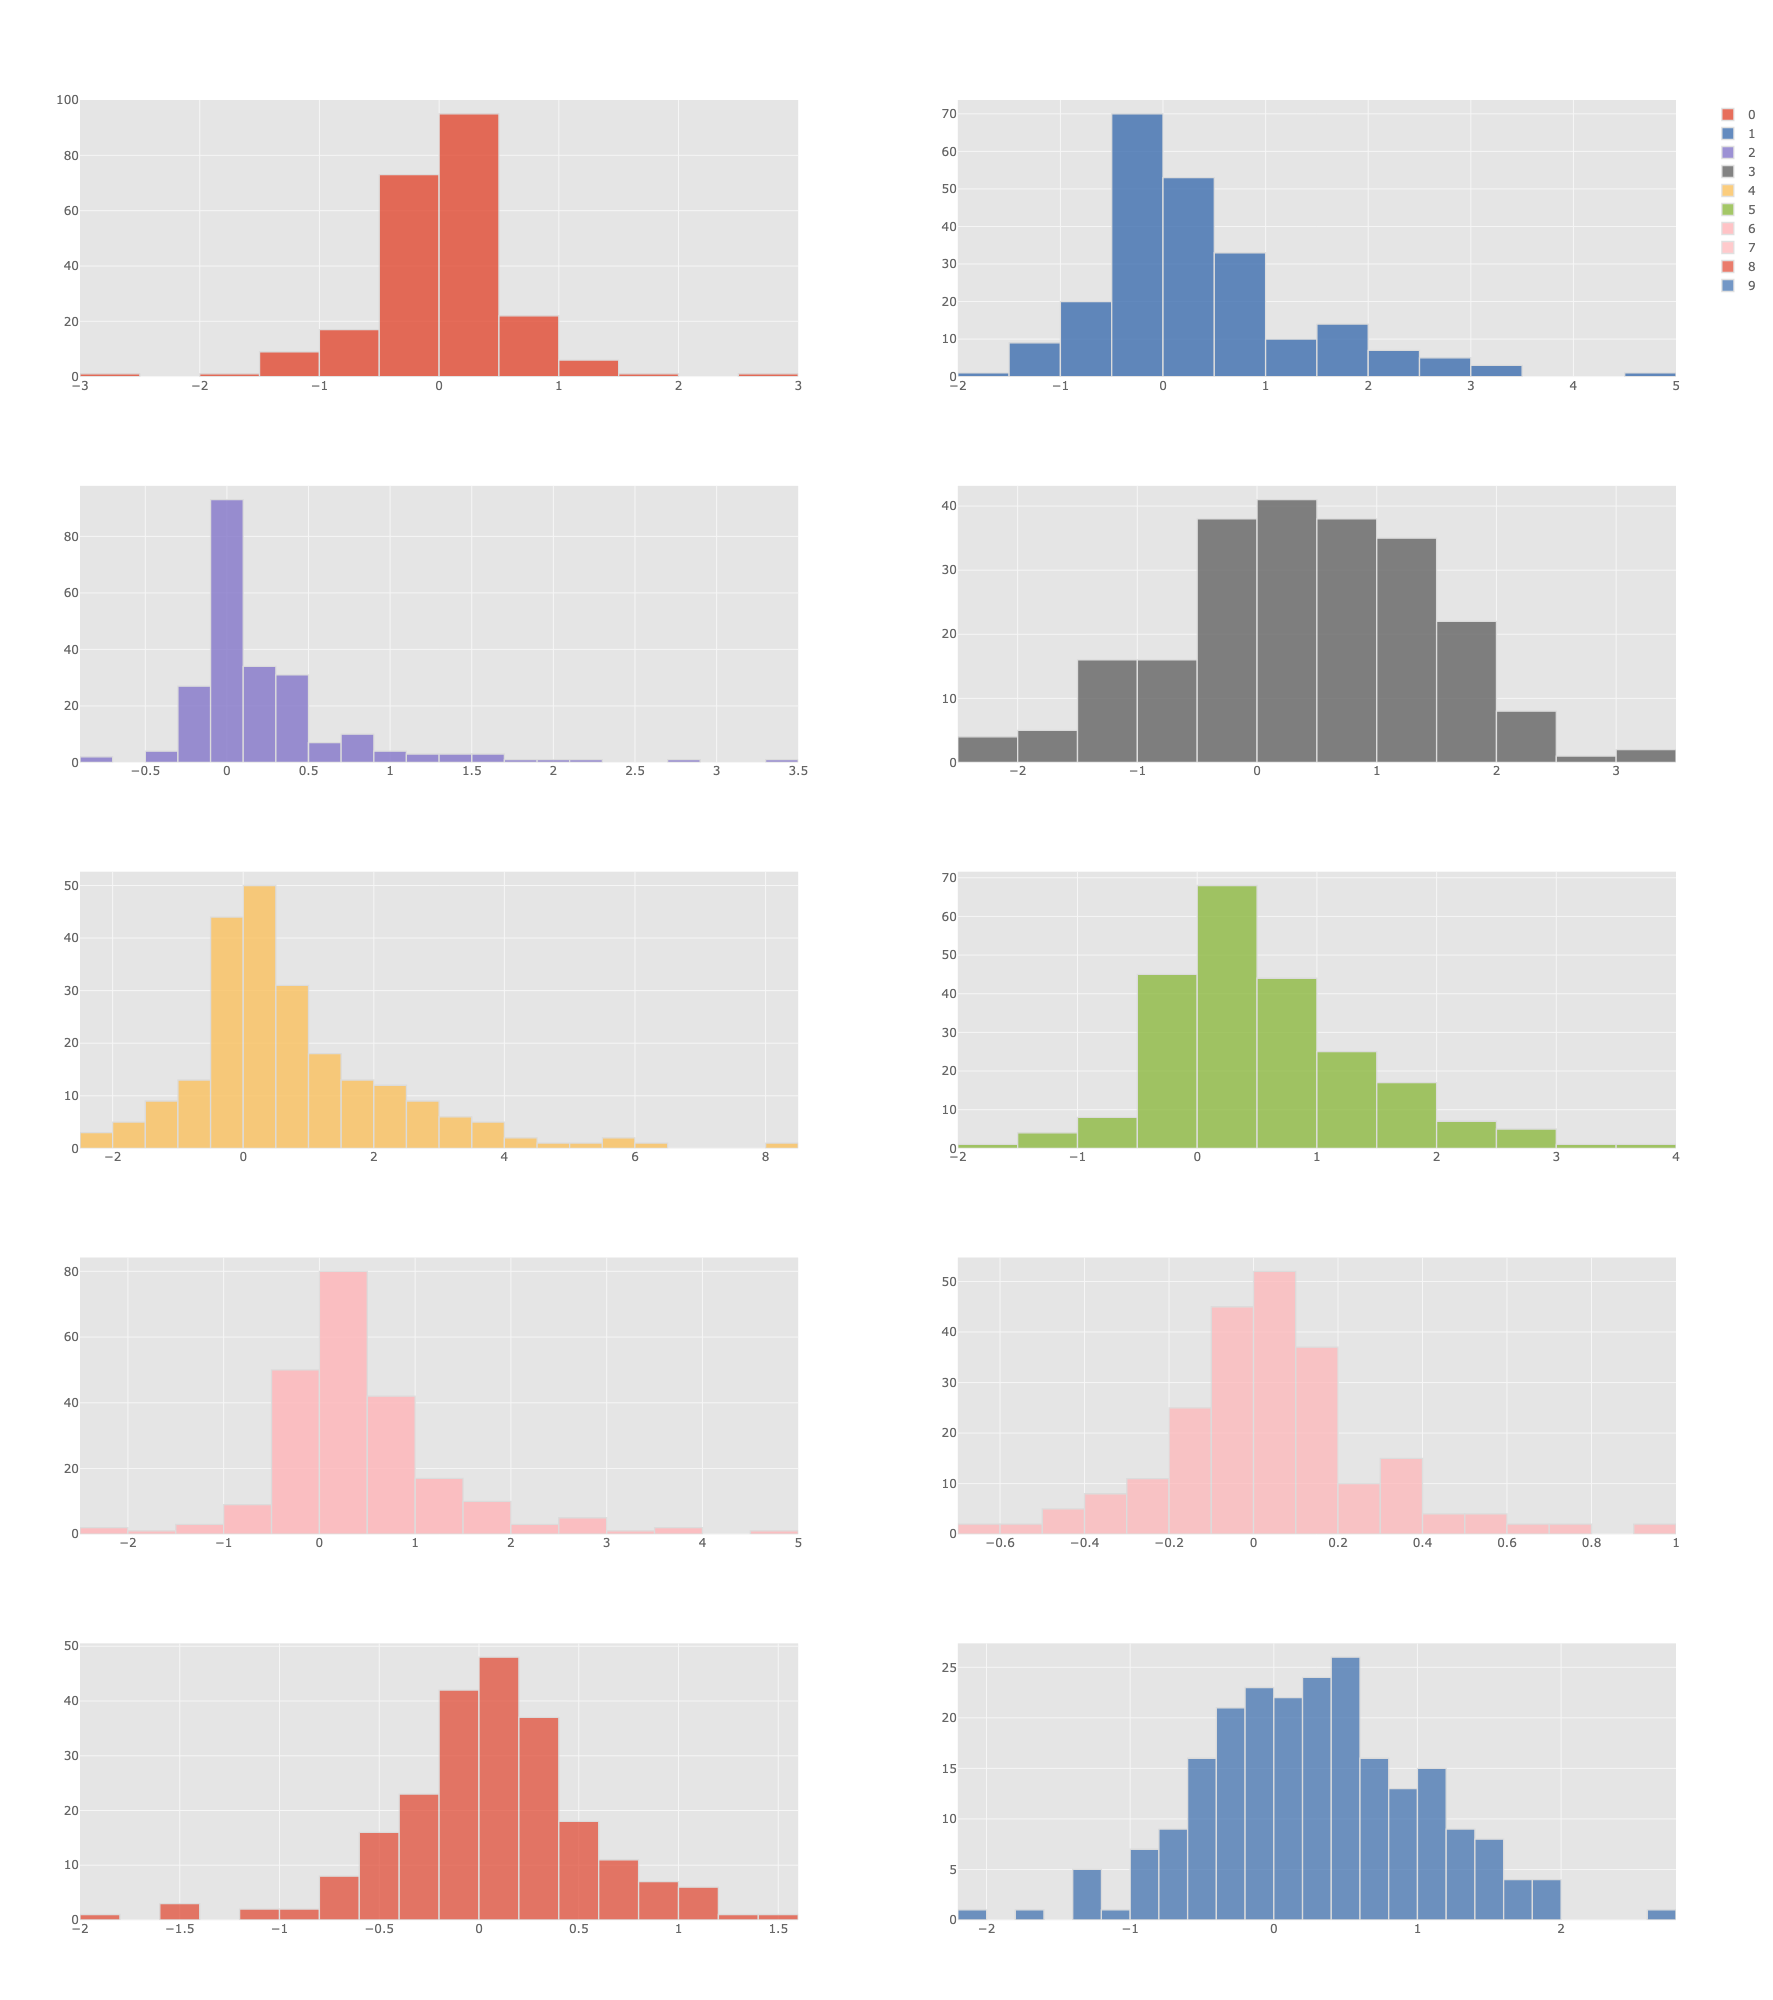

In [82]:
original_lrp.iplot(kind="histogram", bins=25, subplots=True)

In [85]:
from scipy.special import softmax
softmax_lrp = pd.DataFrame(softmax(original_lrp.values, axis=1))

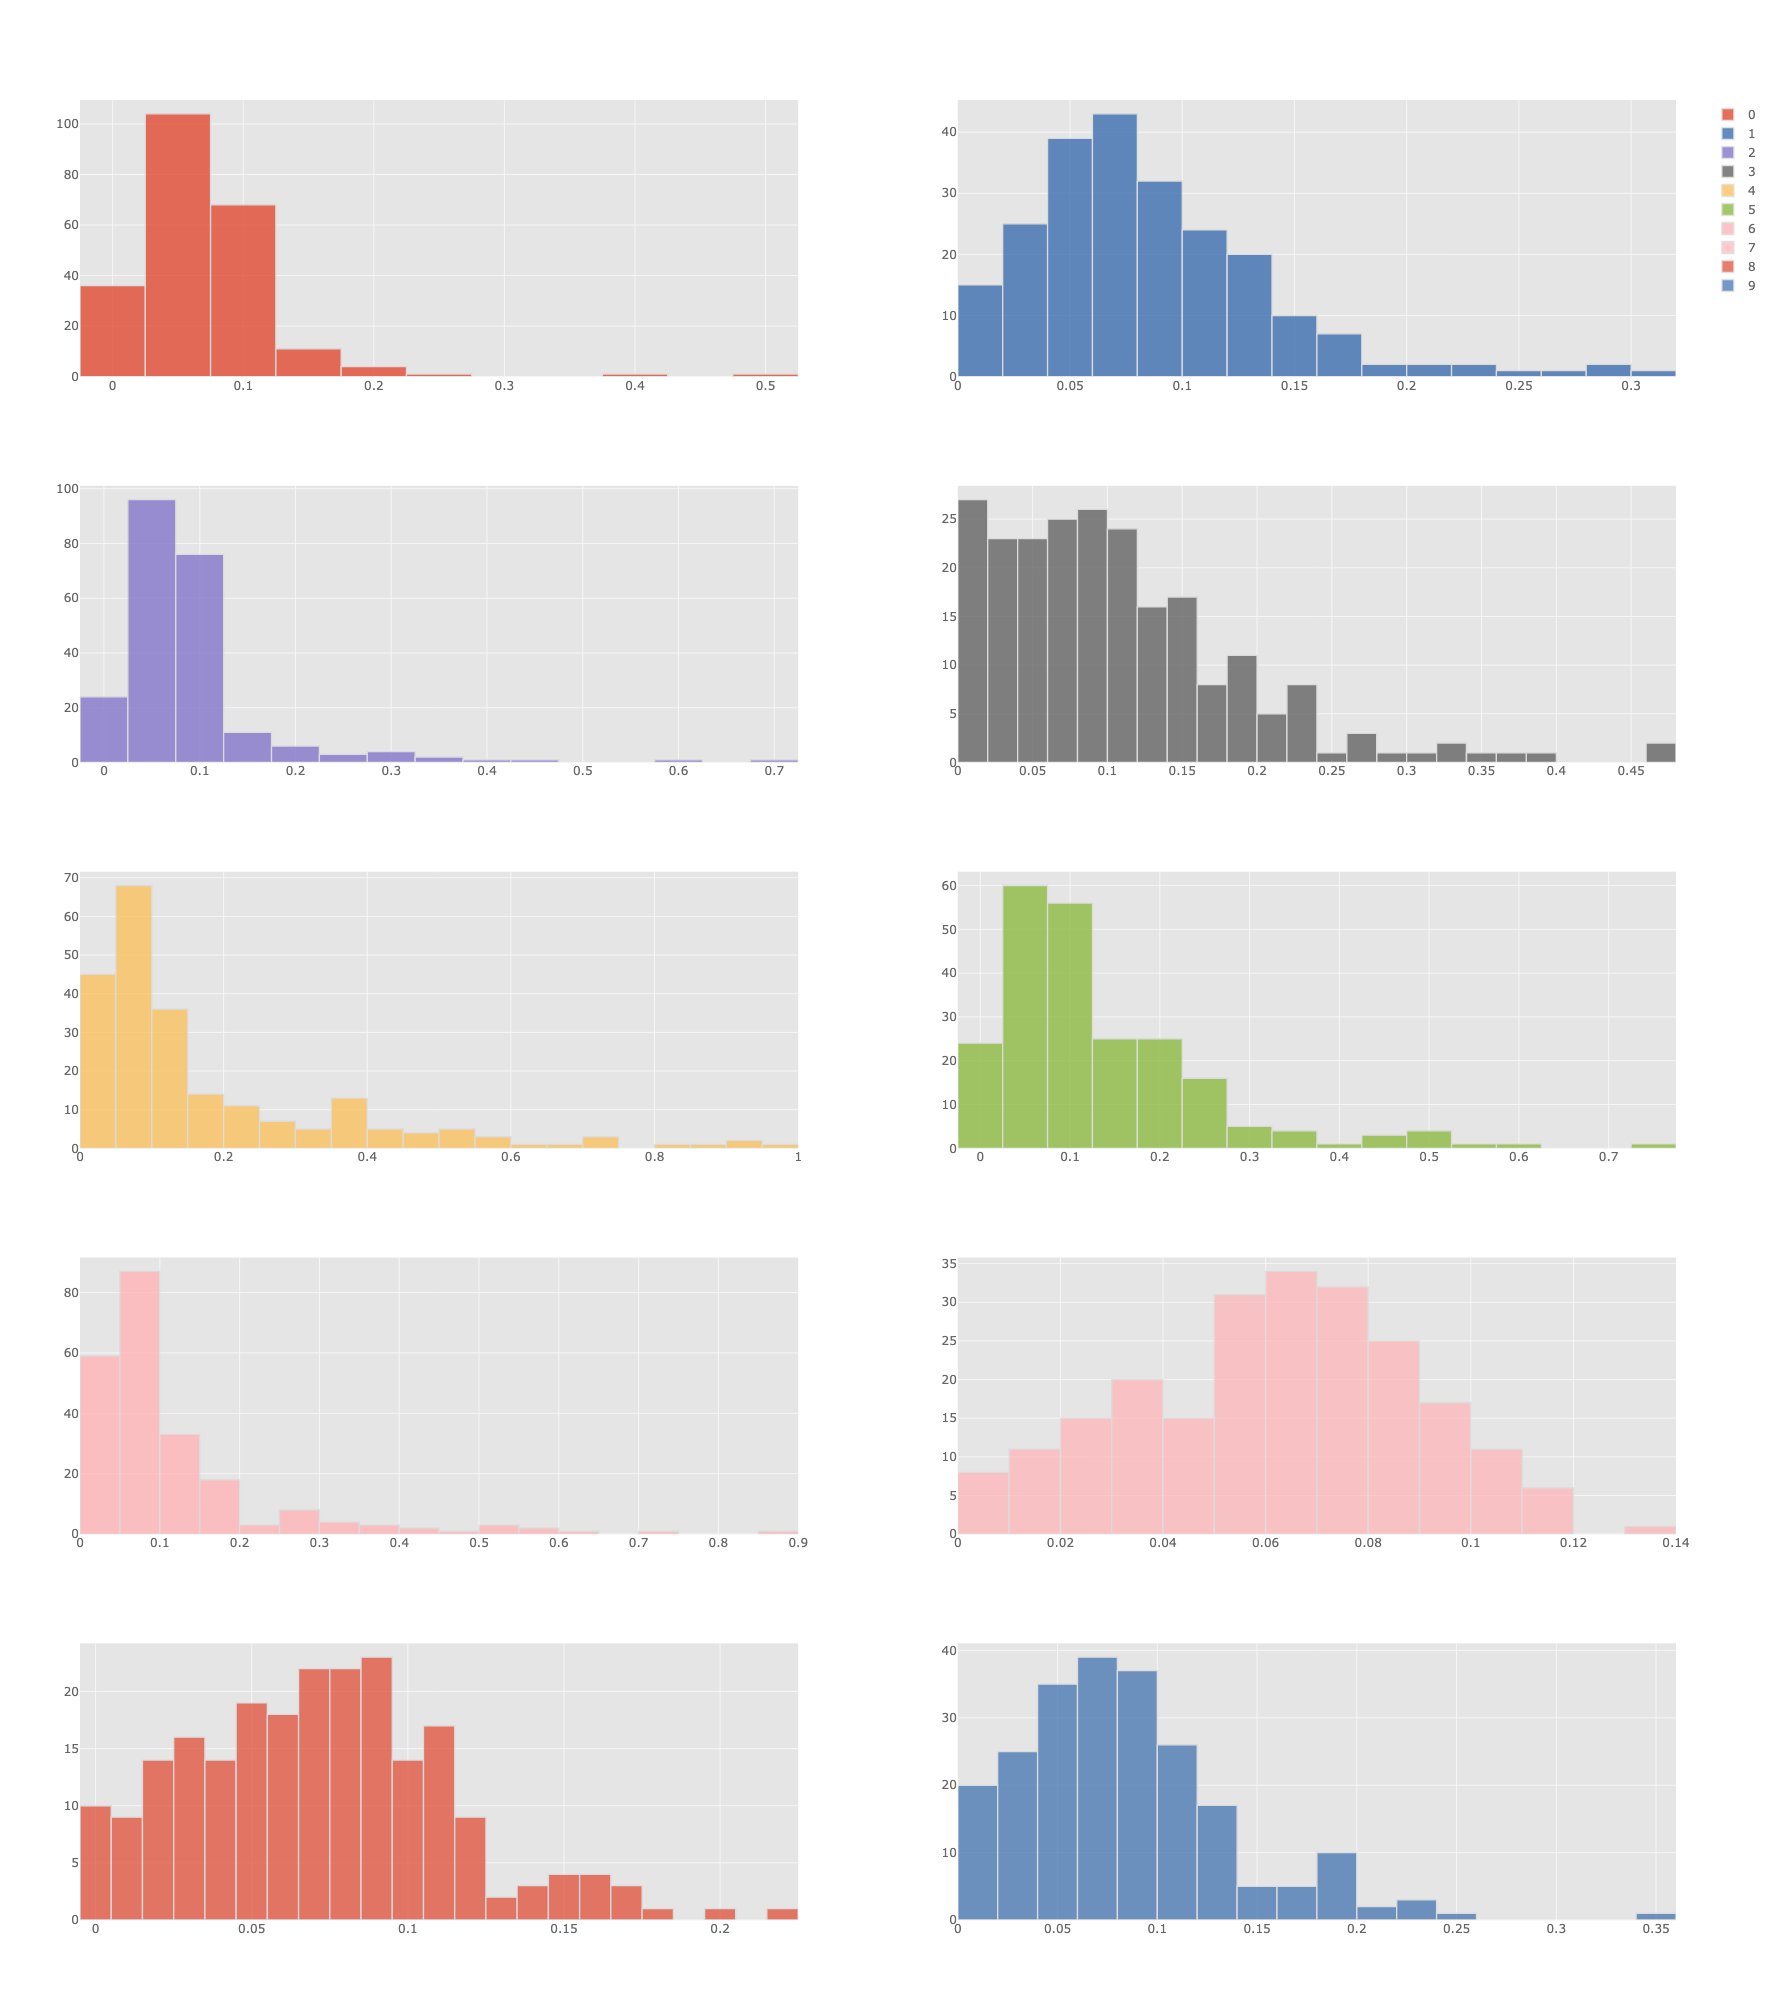

In [87]:
softmax_lrp.iplot(kind="histogram", bins=25, subplots=True)

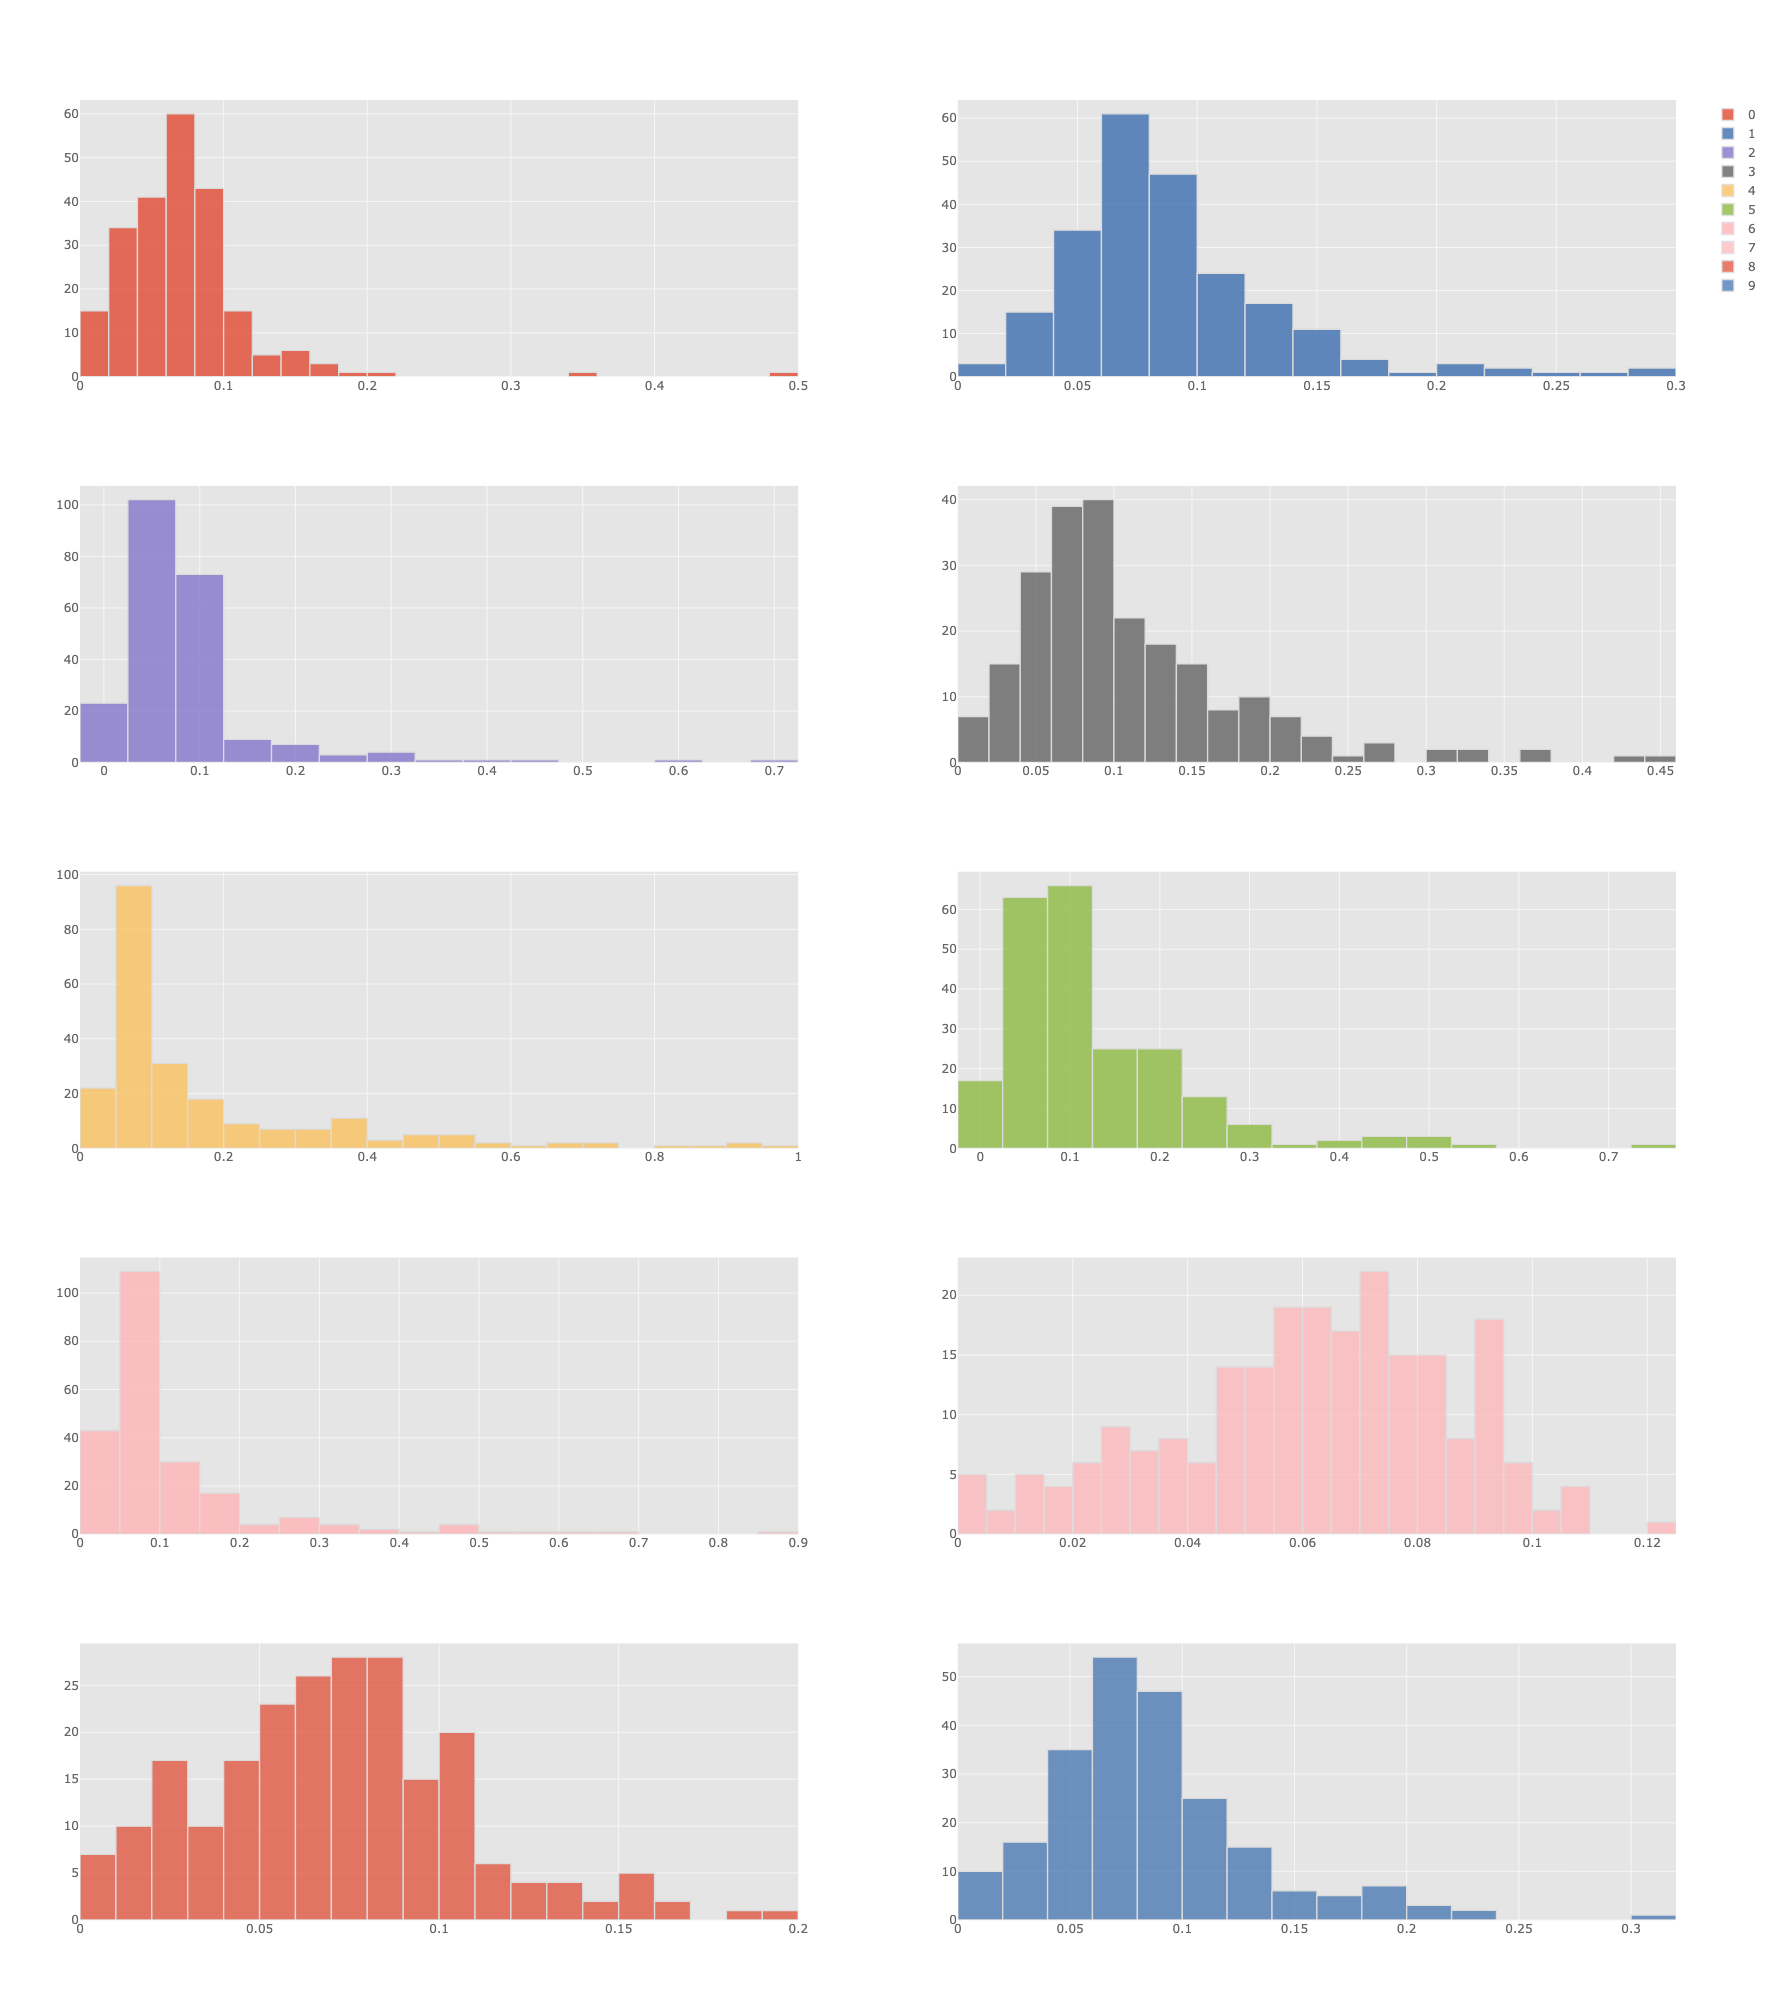

In [94]:
softmax_clipped_lrp = pd.DataFrame(softmax(pipeline.training_lrp, axis=1))
softmax_clipped_lrp.iplot(kind="histogram", bins=25, subplots=True)

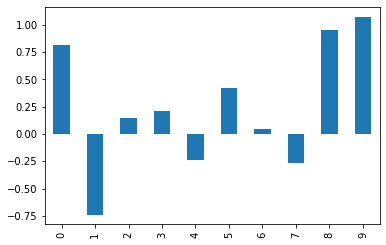

In [92]:
original_lrp.iloc[0].plot(kind="bar")

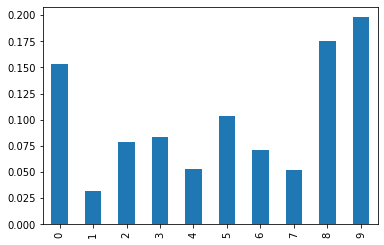

In [93]:
softmax_lrp.iloc[0].plot(kind="bar")

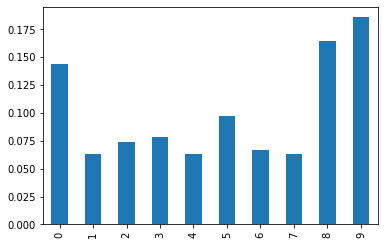

In [95]:
softmax_clipped_lrp.iloc[0].plot(kind="bar")

In [102]:
def plot_lrp(lrp):
    
    embedding_pipeline = Pipeline([
        ("reducer", umap.UMAP(random_state=42,
                        n_components = 3,
                        n_neighbors=15,
                        min_dist=0)),
       ("scaler", MinMaxScaler())
    ])
    embedding_pipeline.fit(lrp)
    embedding = embedding_pipeline.transform(lrp)
    
    
    emb3d = go.Scatter3d(
        x=embedding[:,0],
        y=embedding[:,1],
        z=embedding[:,2],
        mode="markers",
        name="Training",
        marker=dict(
            size=5,
#             color=pipeline.clusterer.labels_,
            colorscale="Rainbow",
            opacity=0.8
        ),
#         text=pipeline.clusterer.labels_
    )

    layout = go.Layout(
        title="3D LRP Embedding",
        autosize=False,
        width=1200,
        height=1000,
        paper_bgcolor='#F5F5F5',
    #     template="plotly"
    )


    data=[emb3d]

    fig = go.Figure(data=data, layout=layout)
    # fig.update_layout(template="plotly")  /

    iplot(fig, filename='lrp-3d-scatter.html')

> ## TODO: Color using original labels

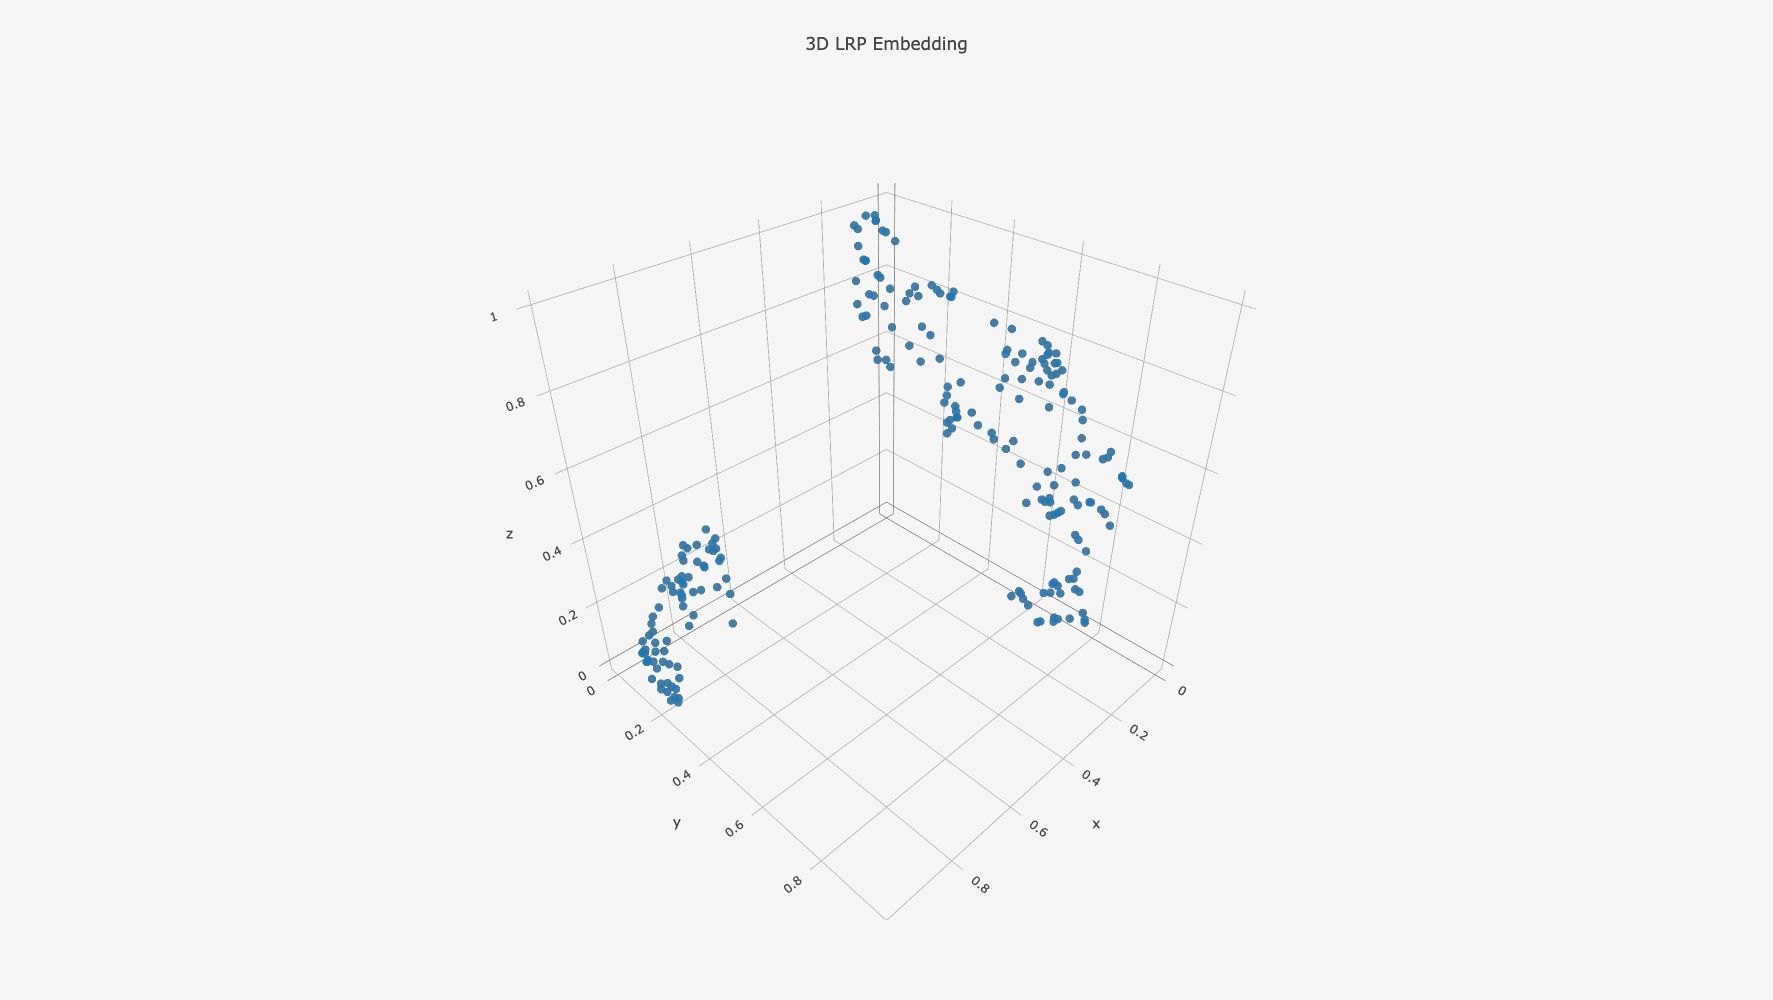

In [105]:
plot_lrp(original_lrp)

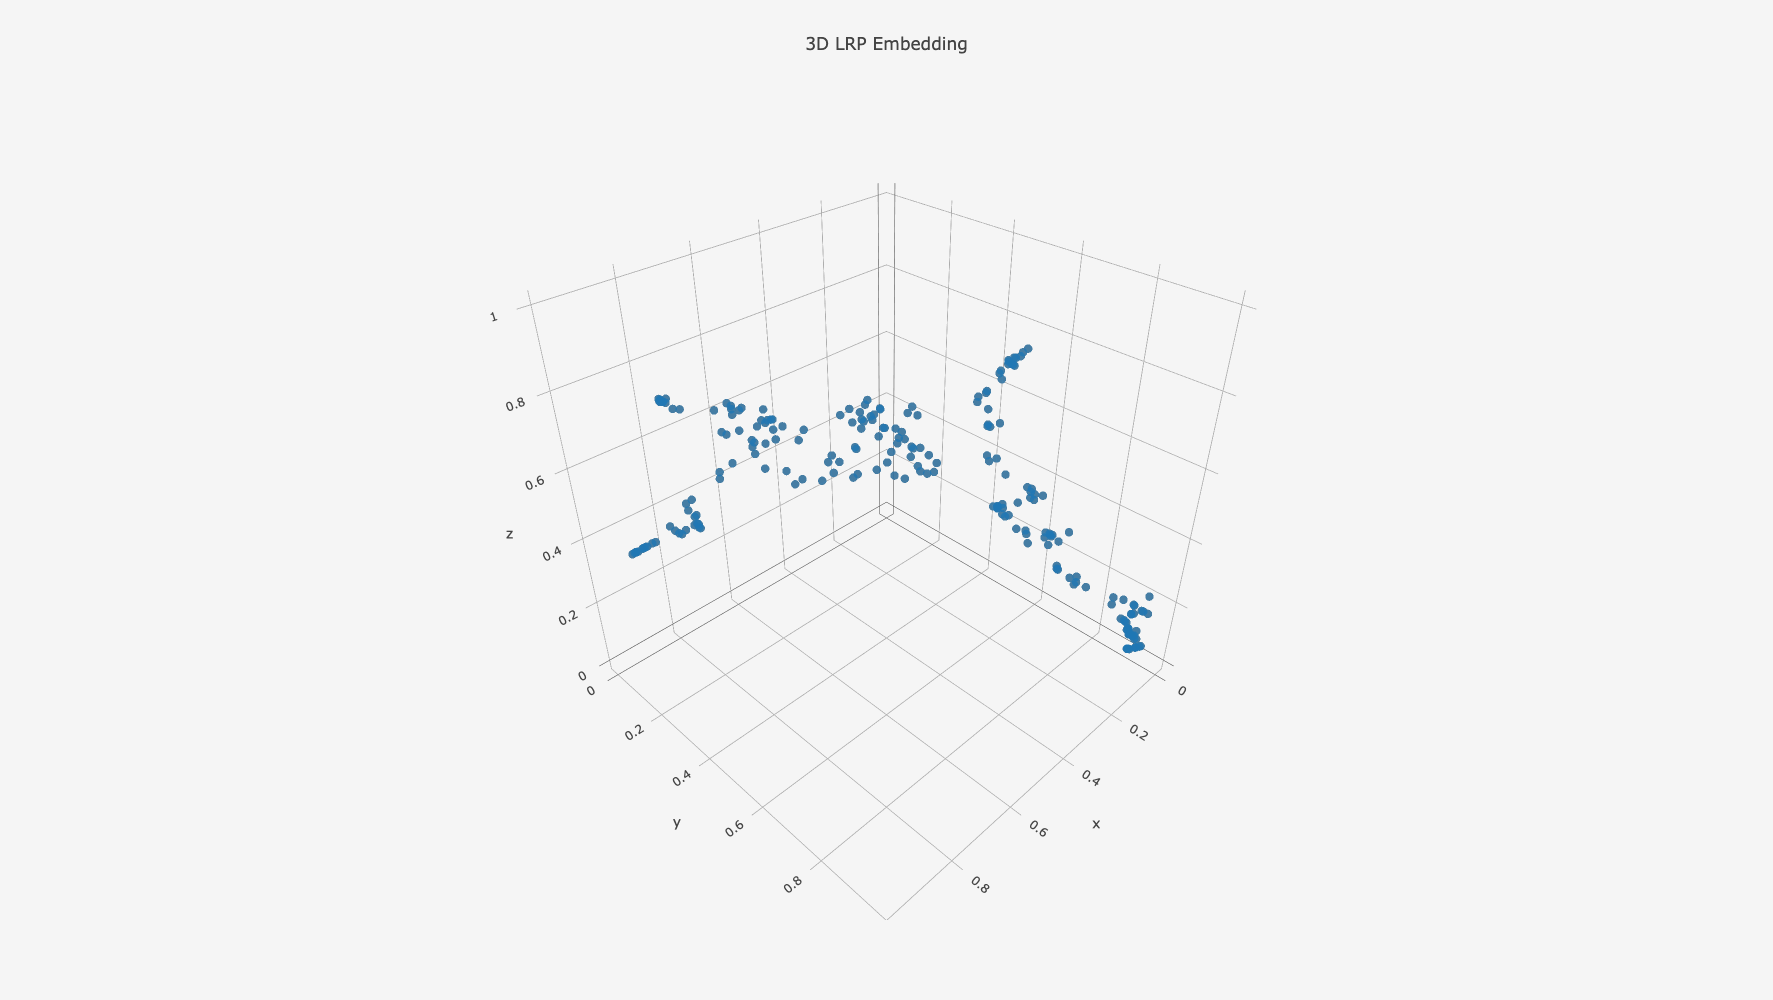

In [106]:
plot_lrp(softmax_lrp)

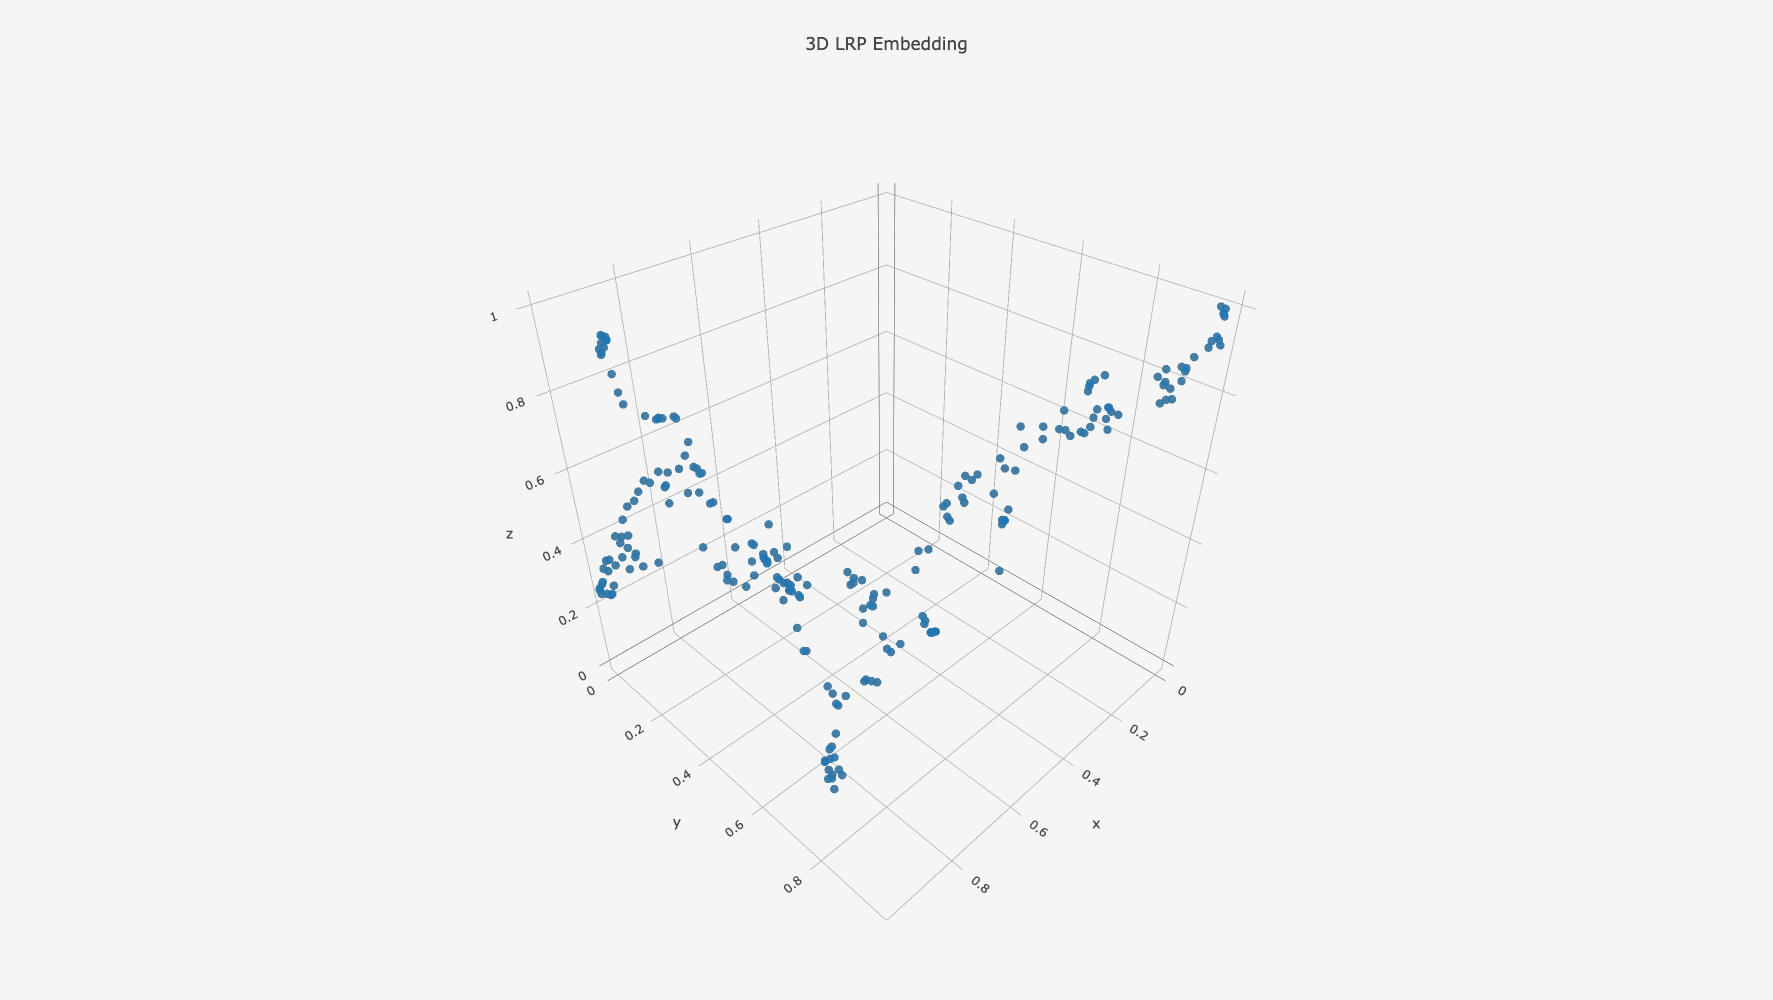

In [107]:
plot_lrp(softmax_clipped_lrp)

In [46]:
####### pipeline lrp = non clipped softmax ########

_, correct_pred_idxs = pipeline.train_clusterer(plot=False)

Minimum Size:
Clusters                  (52, 52)
Noise                     (52, 52)
Halkidi                   (50, 50)
Halkidi-Filtered Noise    (50, 50)
dtype: object


In [47]:
max(pipeline.clusterer.labels_)

9

In [43]:
def plot_clusters(lrp):
    
    training_lrp = pipeline.training_lrp
    
    # Internally populates self.val_set_lrp
    samples, cluster_labels = pipeline.get_validation_clusters()
    
    val_lrp = pipeline.val_set_lrp
    # pipeline.reducer_pipeline[0].n_neighbors
    embedding_pipeline = Pipeline([
        ("reducer", umap.UMAP(random_state=42,
                        n_components = 3,
                        n_neighbors=15,
                        min_dist=0.1)),
       ("scaler", MinMaxScaler())
    ])
    embedding_pipeline.fit(training_lrp)

    embedding = embedding_pipeline.transform(training_lrp)

    emb3d = go.Scatter3d(
        x=embedding[:,0],
        y=embedding[:,1],
        z=embedding[:,2],
        mode="markers",
        name="Training",
        marker=dict(
            size=2,
            color=pipeline.clusterer.labels_,
            colorscale="Rainbow",
            opacity=0.8
        ),
        text=pipeline.clusterer.labels_
    )

    val_3d_embedding = embedding_pipeline.transform(val_lrp)

    val_emb3d = go.Scatter3d(
        x=val_3d_embedding[:,0],
        y=val_3d_embedding[:,1],
        z=val_3d_embedding[:,2],
        name="Validation",
        mode="markers",
        marker=dict(
            size=5,
            color=cluster_labels,
            colorscale='Viridis',
            opacity=0.8,
            showscale=True
        ),
        text = cluster_labels
    )

    layout = go.Layout(
        title="3D LRP Embedding",
        autosize=False,
        width=1200,
        height=1000,
        paper_bgcolor='#F5F5F5',
    #     template="plotly"
    )


    data=[emb3d, val_emb3d]

    fig = go.Figure(data=data, layout=layout)
    # fig.update_layout(template="plotly")  /

    iplot(fig, filename='lrp-3d-scatter.html')

Prediction Accuracy: 0.9269


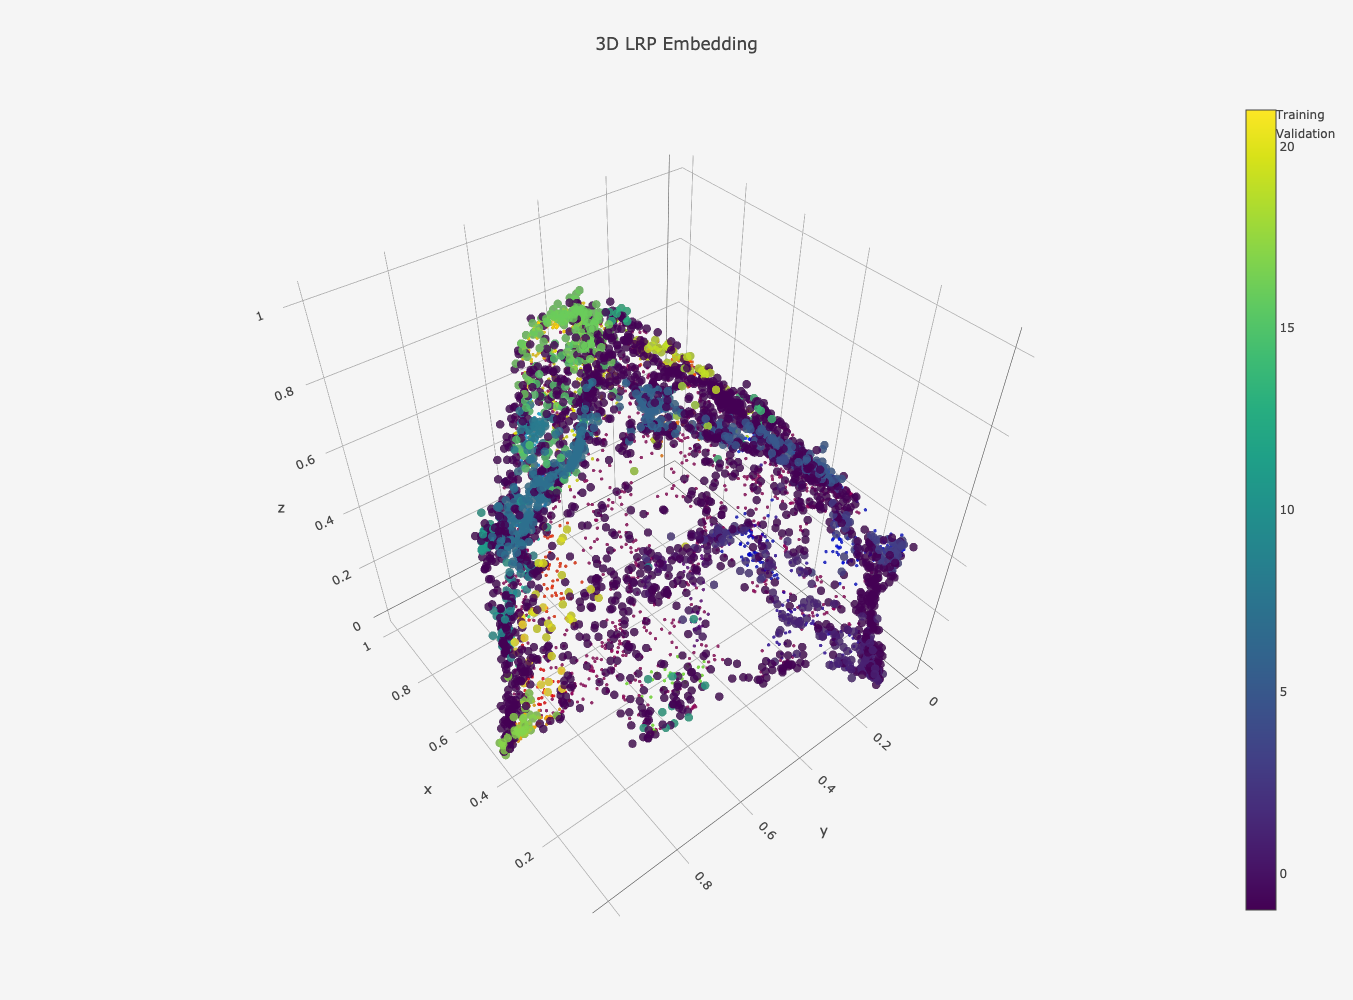

In [44]:
plot_clusters(pipeline)

In [21]:
# Are the actual subclasses extracted?
# test_data, test_labels

In [22]:
test_data.shape

(4500, 10)

In [27]:
# Internally populates self.val_set_lrp
val_samples_target, cluster_labels = pipeline.get_validation_clusters()

In [29]:
best_predictions, best_DNN = pipeline.get_predictions()

# Only consider the samples from the class(es) which are expected to have subclusters
control_class = best_predictions != pipeline.target_class
val_samples_control = pipeline.val_set.features.values[pipeline.val_pred_mask][control_class]
control_labels = pipeline.val_set.features.values[pipeline.val_pred_mask][control_class]

Prediction Accuracy: 0.9213


In [32]:
print("Control:", val_samples_control.shape)
print("Target:", val_samples_target.shape)

Control: (2531, 10)
Target: (2306, 10)


# TODO: Check if subclusters match with original classes